Text(0.5, 1.0, 'SO-50 elevation @ CN94\n2018-11-19T00:00:00Z to 2018-11-19T23:59:00Z')

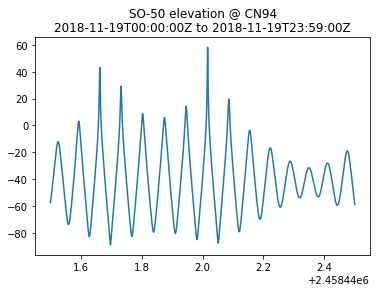

In [10]:
'''
2018-11-20
following along with <https://github.com/skyfielders/astronomy-notebooks/blob/master/Solvers/Earth-Satellite-Passes.ipynb>
'''

from skyfield.api import load, Topos, earth, JulianDate
import matplotlib.pyplot as plt
from scipy import optimize
import maidenhead as mh
import numpy as np

ts = load.timescale()

tau = 2.0 * np.pi

'''CONFIGURE ME!!!!'''
tle = load.tle('data/tle/amateur.txt')
src_mh = 'CN94'
# do every minute for 24 hours starting on 2018-11-19 0000Z UTC
time_range = ts.utc(2018, 11, 19, 0, range(0, 24 * 60, 1))

home = Topos(*mh.toLoc(src_mh))
satellite = 'SO-50'
#sat = tle['AO-92']
sat = tle[satellite]

diff = sat - home

def alt_f(t):
    return diff.at(t).altaz()[0].degrees

altitudes = alt_f(time_range)
plt.plot(time_range.tai, altitudes)
plt.title('{} elevation @ {}\n{} to {}'.format(
        satellite
        , src_mh
        , time_range[0].utc_iso()
        , time_range[-1].utc_iso()
    )
)

In [19]:
# try every sixth for gr8 speed
orbit_period_per_minute = (2.0 * np.pi) / sat.model.no
orbit_period = orbit_period_per_minute / 24.0 / 60.0
revolutions_per_day = 1.0 / orbit_period # this should approximate the number of peaks
print(revolutions_per_day, 'revolutions per day')
print(orbit_period_per_minute)
print(orbit_period / 6.0)
revs_per_hour = revolutions_per_day / 24.0
revs_per_minute = revolutions_per_day / (24.0 * 60.0)
print(revs_per_hour, revs_per_minute)
print(1.0 / revs_per_hour, 1.0 / revs_per_minute)

period_hex = ts.utc(2018, 11, 19, 0, 0, range(0, 24 * 60, int(10.0 * orbit_period)))

# revolutions_per_day should approximate the number of peaks in the plot

14.75939188361623 revolutions per day
97.56499531654028
0.011292244828303273
0.614974661817343 0.010249577696955715
1.6260832552756712 97.56499531654028


ValueError: range() arg 3 must not be zero

In [ ]:
left_diff = ediff1d(altitude, to_begin=0.0)
right_diff = ediff1d(altitude, to_end=0.0)
maxima = (left_diff > 0.0) & (right_diff < 0.0)